# ML-powered Indoor Temperature Prediction based on Simulation-based Temperature

- Created by Htoo Inzali - htoo.inzali@rwth-aachen.de - htooinzali570@gmail.com

This notebook is a project of "CR_Prototyping Project" course at RWTH Construction Robotics Master Program. In this notebook, the room temperature of a simple room will be predicted using Machine Learning based on the data simulated in openModelica. 

In [1]:
import os
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%matplotlib inline

## 1. Preprocessing

### Load data 

In [3]:
os.chdir("/Users/hiz/Desktop/RWTH_3rdSem/CR_Protyping Project DSS - BIM/Project/Inzali_Berweiler_IndoorTemperaturePrediction_ss23_prototype/2_simulatedData")

In [4]:
# List all the CSV files in the above directory. 
csv_files = ['winter_JanFeb.csv', 'spring_MarAprMay.csv', 'summer_JunJulAug.csv', 'autumn_SeptOctNov.csv', 'winter_Dec.csv']

# Create an empty list to store dataframes from each csv file. 
data_frames = []

# Loop through all the CSV files and combine(append) them. 
for csv_file in csv_files:
    data_frame = pd.read_csv(csv_file)
    data_frames.append(data_frame)
    
# Concatenate all dataframes into a single dataframe.
df = pd.concat(data_frames, ignore_index=True)

In [5]:
df.sample(10)

,time,importWeatherModified.min,importWeatherModified.h,importWeatherModified.dm,importWeatherModified.dy,importWeatherModified.FF,importWeatherModified.S_height,window_Status_hour_of_day_Winter.Window_Status,importWeatherModified.port_a.T,port_a.T,window_Status_hour_of_day_Spring.Window_Status,window_Status_hour_of_day_Summer.Window_Status,window_Status_hour_of_day_Autumn.Window_Status
2871320,24606300.0,5,19,12,285,1.6,-13.0,NaN,294.75,295.054361,NaN,NaN,1.0
1690833,14489900.0,58,16,17,168,2.3,33.1,NaN,297.95,298.762975,NaN,2.0,NaN
3000402,25712500.0,22,14,25,298,2.0,28.0,NaN,291.75,291.682894,NaN,NaN,2.0
5773,49450.0,45,13,1,1,3.2,21.9,1.0,287.15,288.494573,NaN,NaN,NaN
3516629,30136400.0,13,19,15,349,0.8,-23.4,1.0,285.15,285.127652,NaN,NaN,NaN
27274,233710.0,56,16,3,3,3.5,1.3,1.0,286.75,288.021673,NaN,NaN,NaN
2911673,24952100.0,9,19,16,289,1.7,-14.9,NaN,290.75,293.548942,NaN,NaN,1.0
142376,1220110.0,56,2,15,15,3.2,-54.7,1.0,271.75,280.723907,NaN,NaN,NaN
3531247,30261600.0,1,6,17,351,3.9,-20.9,1.0,281.05,284.997068,NaN,NaN,NaN
354911,3041480.0,52,4,5,36,3.6,-32.0,1.0,277.75,283.836811,NaN,NaN,NaN


### Getting general insight of the original dataset

In [6]:
df.shape

(3679952, 13)

In [7]:
df.describe()

,time,importWeatherModified.min,importWeatherModified.h,importWeatherModified.dm,importWeatherModified.dy,importWeatherModified.FF,importWeatherModified.S_height,window_Status_hour_of_day_Winter.Window_Status,importWeatherModified.port_a.T,port_a.T,window_Status_hour_of_day_Spring.Window_Status,window_Status_hour_of_day_Summer.Window_Status,window_Status_hour_of_day_Autumn.Window_Status
count,3.679952e+06,3.679952e+06,3.679952e+06,3.679952e+06,3.679952e+06,3.679952e+06,3.679952e+06,907386.000000,3.679952e+06,3.679952e+06,927550.000000,927548.000000,917468.000000
mean,1.576800e+07,2.949792e+01,1.149976e+01,1.572055e+01,1.830002e+02,3.180580e+00,3.223861e-01,1.125155,2.885852e+02,2.918396e+02,1.291805,1.625270,1.416767
std,9.103665e+06,1.731893e+01,6.921565e+00,8.796301e+00,1.053663e+02,2.369005e+00,3.446694e+01,0.330895,7.466863e+00,6.237607e+00,0.610973,0.753638,0.640188
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.020000e+01,1.000000,2.701500e+02,2.774534e+02,1.000000,1.000000,1.000000
25%,7.883988e+06,1.400000e+01,6.000000e+00,8.000000e+00,9.200000e+01,1.400000e+00,-2.600000e+01,1.000000,2.829500e+02,2.863282e+02,1.000000,1.000000,1.000000
50%,1.576800e+07,2.900000e+01,1.100000e+01,1.600000e+01,1.830000e+02,2.600000e+00,3.000000e-01,1.000000,2.885500e+02,2.916275e+02,1.000000,1.000000,1.000000
75%,2.365200e+07,4.400000e+01,1.700000e+01,2.300000e+01,2.740000e+02,4.400000e+00,2.670000e+01,1.000000,2.941500e+02,2.969824e+02,1.000000,2.000000,2.000000
max,3.153600e+07,5.900000e+01,2.400000e+01,3.100000e+01,3.650000e+02,1.610000e+01,7.020000e+01,2.000000,3.088500e+02,3.058494e+02,3.000000,3.000000,3.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679952 entries, 0 to 3679951
Data columns (total 13 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   time                                            float64
 1   importWeatherModified.min                       int64  
 2   importWeatherModified.h                         int64  
 3   importWeatherModified.dm                        int64  
 4   importWeatherModified.dy                        int64  
 5   importWeatherModified.FF                        float64
 6   importWeatherModified.S_height                  float64
 7   window_Status_hour_of_day_Winter.Window_Status  float64
 8   importWeatherModified.port_a.T                  float64
 9   port_a.T                                        float64
 10  window_Status_hour_of_day_Spring.Window_Status  float64
 11  window_Status_hour_of_day_Summer.Window_Status  float64
 12  window_Status_hour_of_day_Au

In [9]:
len(df)

3679952

In [10]:
df['port_a.T'].nunique()

3153968

In [11]:
df['importWeatherModified.dm'].value_counts()

28    120986
1     120985
16    120984
27    120984
26    120984
25    120984
24    120984
23    120984
22    120984
21    120984
20    120984
19    120984
18    120984
17    120984
15    120984
14    120984
13    120984
12    120984
11    120984
10    120984
9     120984
8     120984
7     120984
6     120984
5     120984
4     120984
3     120984
2     120984
30    110902
29    110902
31     70583
0         10
Name: importWeatherModified.dm, dtype: int64

### Identify and handle missing values

#### Evaluating for Missing Data

The missing values are converted by default. We use the following functions to identify these missing values. There are two methods to detect missing data:

.isnull()

.notnull()

The output is a boolean value indicating whether the value that is passed into the argument is in fact missing data.

In [12]:
missing_data = df.isnull()
missing_data.head(10)

,time,importWeatherModified.min,importWeatherModified.h,importWeatherModified.dm,importWeatherModified.dy,importWeatherModified.FF,importWeatherModified.S_height,window_Status_hour_of_day_Winter.Window_Status,importWeatherModified.port_a.T,port_a.T,window_Status_hour_of_day_Spring.Window_Status,window_Status_hour_of_day_Summer.Window_Status,window_Status_hour_of_day_Autumn.Window_Status
0,False,False,False,False,False,False,False,False,False,False,True,True,True
1,False,False,False,False,False,False,False,False,False,False,True,True,True
2,False,False,False,False,False,False,False,False,False,False,True,True,True
3,False,False,False,False,False,False,False,False,False,False,True,True,True
4,False,False,False,False,False,False,False,False,False,False,True,True,True
5,False,False,False,False,False,False,False,False,False,False,True,True,True
6,False,False,False,False,False,False,False,False,False,False,True,True,True
7,False,False,False,False,False,False,False,False,False,False,True,True,True
8,False,False,False,False,False,False,False,False,False,False,True,True,True
9,False,False,False,False,False,False,False,False,False,False,True,True,True


#### Count missing values in each column

Using a for loop in Python, we can quickly figure out the number of missing values in each column. As mentioned above, "True" represents a missing value and "False" means the value is present in the dataset.  In the body of the for loop the method ".value_counts()" counts the number of "True" values. 

In [13]:
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

time
False    3679952
Name: time, dtype: int64

importWeatherModified.min
False    3679952
Name: importWeatherModified.min, dtype: int64

importWeatherModified.h
False    3679952
Name: importWeatherModified.h, dtype: int64

importWeatherModified.dm
False    3679952
Name: importWeatherModified.dm, dtype: int64

importWeatherModified.dy
False    3679952
Name: importWeatherModified.dy, dtype: int64

importWeatherModified.FF
False    3679952
Name: importWeatherModified.FF, dtype: int64

importWeatherModified.S_height
False    3679952
Name: importWeatherModified.S_height, dtype: int64

window_Status_hour_of_day_Winter.Window_Status
True     2772566
False     907386
Name: window_Status_hour_of_day_Winter.Window_Status, dtype: int64

importWeatherModified.port_a.T
False    3679952
Name: importWeatherModified.port_a.T, dtype: int64

port_a.T
False    3679952
Name: port_a.T, dtype: int64

window_Status_hour_of_day_Spring.Window_Status
True     2752402
False     927550
Name: window_Status_hour_o

Based on the result above, the following columns has missing values 

1. window_Status_hour_of_day_Winter.Window_Status
2. window_Status_hour_of_day_Spring.Window_Status
3. window_Status_hour_of_day_Summer.Window_Status
4. window_Status_hour_of_day_Autumn.Window_Status

In fact, we know that the values of all window_status should be in one single column and this is due to the different column naming in the csv files which we concated earlier.  

#### Dealing with missing data

There are a few common methods to deal with missing data such as dropping or replacing. Howeveer, in our particular case, combining those values in one colum would be the most suitable way. 

In [14]:
# Combine all the Window_Status columns into a single column called 'Window_Status_All'
df['windowStatus'] = df[['window_Status_hour_of_day_Winter.Window_Status',
                              'window_Status_hour_of_day_Spring.Window_Status',
                              'window_Status_hour_of_day_Summer.Window_Status',
                              'window_Status_hour_of_day_Autumn.Window_Status']].sum(axis=1)

# Drop the individual Window_Status columns since they are now combined
df.drop(columns=['window_Status_hour_of_day_Winter.Window_Status',
                 'window_Status_hour_of_day_Spring.Window_Status',
                 'window_Status_hour_of_day_Summer.Window_Status',
                 'window_Status_hour_of_day_Autumn.Window_Status'], inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679952 entries, 0 to 3679951
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   time                            float64
 1   importWeatherModified.min       int64  
 2   importWeatherModified.h         int64  
 3   importWeatherModified.dm        int64  
 4   importWeatherModified.dy        int64  
 5   importWeatherModified.FF        float64
 6   importWeatherModified.S_height  float64
 7   importWeatherModified.port_a.T  float64
 8   port_a.T                        float64
 9   windowStatus                    float64
dtypes: float64(6), int64(4)
memory usage: 280.8 MB


#### Cleansing and Organising 
 

##### Creating new columns ('month')

In [16]:
import calendar

# Get the name and index of the month from importWeatherModified.dy which is days-in-year
def get_month_info(day):
    year = 2022
    month = 1
    while day > 0:
        days_in_month = calendar.monthrange(year, month)[1]
        if day <= days_in_month:
            break
        day -= days_in_month
        month += 1
    return month, calendar.month_abbr[month],day

# Apply the function to the 'day_in_year' column to create the 'month_index' and 'month_name' columns
df[['month_index', 'month', 'day']] = df['importWeatherModified.dy'].apply(get_month_info).tolist()

# Drop unwanted columns
df.drop(columns=['importWeatherModified.dm',
                'importWeatherModified.dy',
                'importWeatherModified.min',
                'importWeatherModified.h'], inplace=True)

In [17]:
df.columns.tolist()

['time',
 'importWeatherModified.FF',
 'importWeatherModified.S_height',
 'importWeatherModified.port_a.T',
 'port_a.T',
 'windowStatus',
 'month_index',
 'month',
 'day']

In fact, I don't need 'day' and 'month_index' columns as well. And I want to use 'time' as my index of rows in the dataframe. ('time' is seconds-of-year from simulation result) 

##### Dropping unwanted columns

In [18]:
# Drop 'day' column
df.drop(columns=['day', 'month_index'], inplace=True)

#Set 'month_index' as index
df.set_index('time', inplace=True)
df.index.name = None

##### Renaming Columns(Optional)

In [19]:
# Rename the columns
new_column_names = {
    #'time': 'second_of_year',
    'importWeatherModified.FF': 'windspeed',
    'importWeatherModified.S_height': 'sunHeight',
    'importWeatherModified.port_a.T': 'weatherTemp',
    'port_a.T': 'roomTemp'
}

df.rename(columns=new_column_names, inplace=True)

##### Correct data format

.dtype() to check the data type

.astype() to change the data type

In [20]:
df.dtypes

windspeed       float64
sunHeight       float64
weatherTemp     float64
roomTemp        float64
windowStatus    float64
month            object
dtype: object

Change the data type of windowStatus as they are only to indicate whether the window is -

- closed >> 1
- tilted >> 2
- fully-opened >> 3

In [21]:
#  Change the data type
df[["windowStatus"]] = df[["windowStatus"]].astype("int64")

In [22]:
df.dtypes

windspeed       float64
sunHeight       float64
weatherTemp     float64
roomTemp        float64
windowStatus      int64
month            object
dtype: object

In [23]:
df.iloc[753044:753050]

,windspeed,sunHeight,weatherTemp,roomTemp,windowStatus,month
6453330.0,5.8,21.2,289.15,288.821905,1,Mar
6453340.0,5.8,21.2,289.15,288.821276,1,Mar
6453350.0,5.8,21.2,289.15,288.820655,1,Mar
6453360.0,5.8,21.2,289.15,288.820040,1,Mar
6453360.0,5.8,21.1,289.15,288.820040,1,Mar
6453370.0,5.8,21.1,289.15,288.819434,1,Mar


### Data Standardization

Standardization is the process of transforming data into a common format, allowing to make the meaningful comparison. For example, converting the same units for the two feature columns. 

In this case, both weatherTemp and roomTemp are in K. If one of them were in degC, it can be converted to K as follows:

df["roomTempK"] = df["roomTemp"] - 273.15

### Data Normalization

Normalization is the process of transforming values of several variables into a similar range. Typical normalizations include scaling the variable so the variable average is 0, scaling the variable so the variance is 1, or scaling the variable so the variable values range from 0 to 1.

Example

To demonstrate normalization, let's say we want to scale the columns "length", "width" and "height".
Target: would like to normalize those variables so their value ranges from 0 to 1
Approach: replace original value by (original value)/(maximum value)

df['length'] = df['length']/df['length'].max()
df['width'] = df['width']/df['width'].max()


In the current dataset, we are not required to do that. 


### Binning

Binning is a process of transforming continuous numerical variables into discrete categorical 'bins' for grouped analysis. 

- seasons
- months
- window_status

These might be useful in analyzing data later. 

In [24]:
# Group months to seasons
def map_to_season(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun','Jul','Aug']:
        return 'Summer'
    elif month in ['Sep','Oct','Nov']:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['season'] = df['month'].apply(map_to_season)

df['season'].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [25]:
df

,windspeed,sunHeight,weatherTemp,roomTemp,windowStatus,month,season
0.0,0.0,0.0,288.15,289.150000,1,Jan,Winter
0.0,0.0,0.0,288.15,289.150000,1,Jan,Winter
0.0,1.7,-68.4,284.05,289.150000,1,Jan,Winter
10.0,1.7,-68.4,284.05,289.132398,1,Jan,Winter
20.0,1.7,-68.4,284.05,289.115464,1,Jan,Winter
...,...,...,...,...,...,...,...
31536000.0,0.3,-68.5,276.05,283.217353,1,Dec,Winter
31536000.0,0.3,-68.5,276.05,283.215471,1,Dec,Winter
31536000.0,0.3,-68.5,276.05,283.213644,1,Dec,Winter
31536000.0,0.3,-68.5,276.05,283.211865,1,Dec,Winter


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3679952 entries, 0.0 to 31536000.0
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   windspeed     float64
 1   sunHeight     float64
 2   weatherTemp   float64
 3   roomTemp      float64
 4   windowStatus  int64  
 5   month         object 
 6   season        object 
dtypes: float64(4), int64(1), object(2)
memory usage: 224.6+ MB


## 2. Analyzing

To find out which feature/s is/are best for the proposed prediction ML model given the current dataset, individual feature patterns are explored using various visualization methods. 

In [27]:
df.dtypes

windspeed       float64
sunHeight       float64
weatherTemp     float64
roomTemp        float64
windowStatus      int64
month            object
season           object
dtype: object

### Plotting

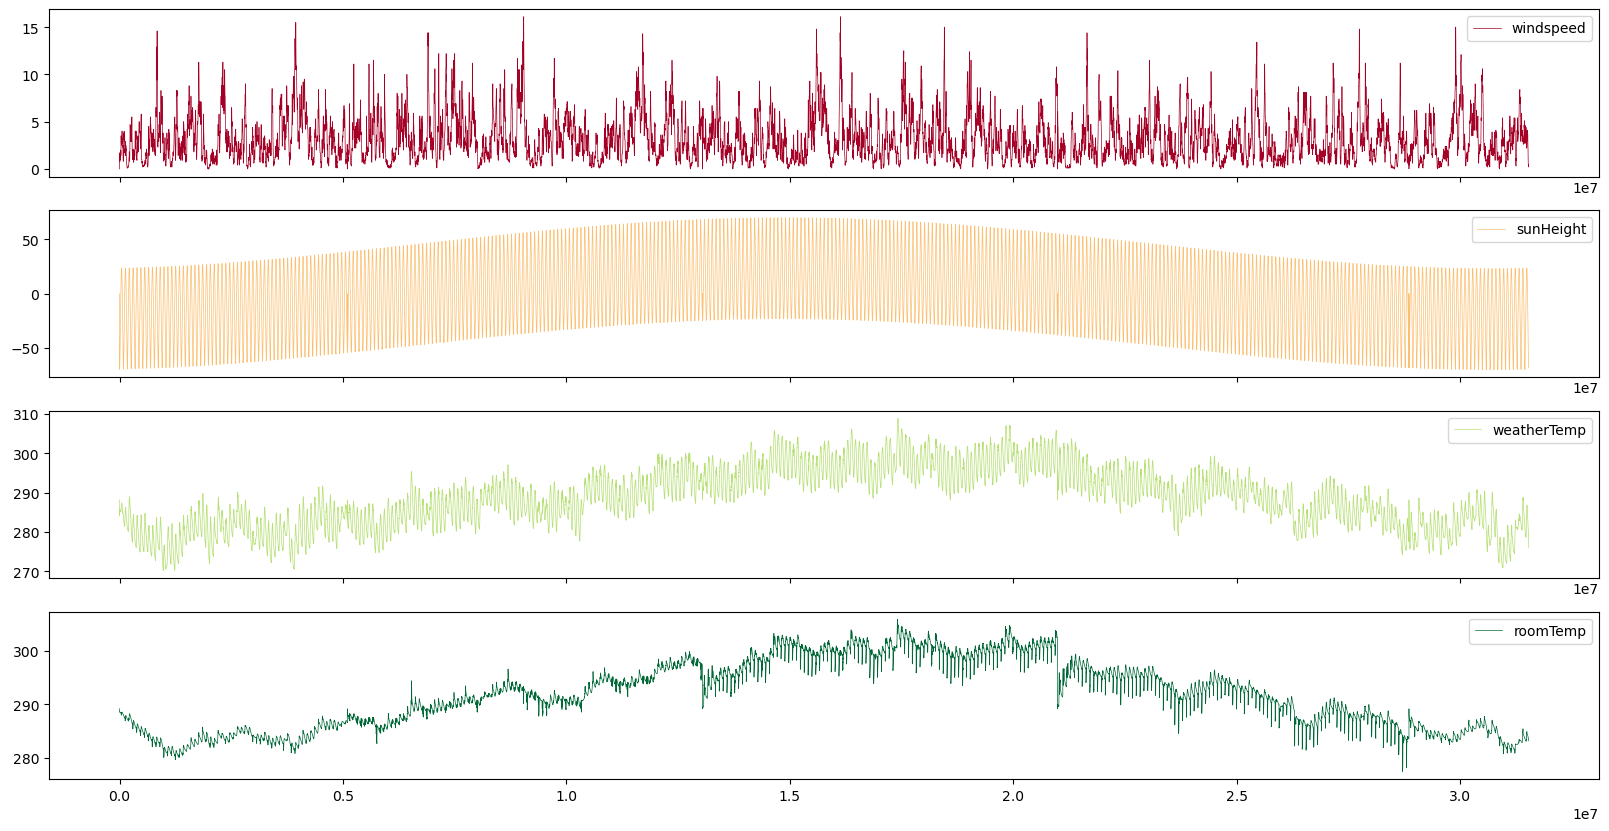

In [28]:
# Select the columns to plot from the DataFrame
columns_to_plot = ['windspeed', 'sunHeight', 'weatherTemp', 'roomTemp']
df_to_plot = df[columns_to_plot]

# Plot the selected columns in subplots
df_to_plot.plot(figsize=(20, 10), subplots=True, lw=0.5, cmap="RdYlGn")

plt.show()

### Correlation

we can calculate the correlation between variables of type "int64" or "float64" using the method "corr":

In [29]:
df.corr()

/var/folders/qb/pvddmz4157vg9z6wk5r_2ylr0000gn/T/ipykernel_19021/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,windspeed,sunHeight,weatherTemp,roomTemp,windowStatus
windspeed,1.000000,0.160677,0.097283,0.021785,0.101831
sunHeight,0.160677,1.000000,0.540736,0.336121,0.616676
weatherTemp,0.097283,0.540736,1.000000,0.901332,0.409763
roomTemp,0.021785,0.336121,0.901332,1.000000,0.213515
windowStatus,0.101831,0.616676,0.409763,0.213515,1.000000


/Users/hiz/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='windspeed', ylabel='roomTemp'>

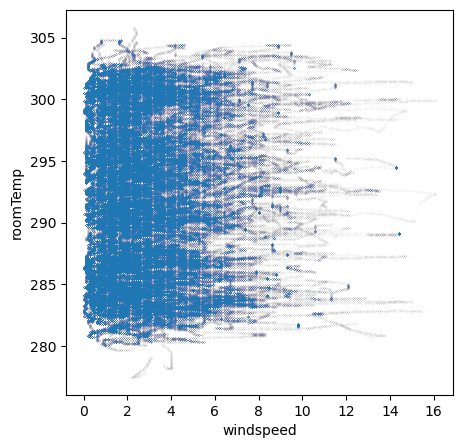

In [30]:
df.plot(kind='scatter', x='windspeed', y='roomTemp', cmap='cool', s=0.00001, lw=1, figsize=(5,5))

In [31]:
df['windspeed'].corr(df['roomTemp'])

0.021784915765295076

<Axes: xlabel='sunHeight', ylabel='roomTemp'>

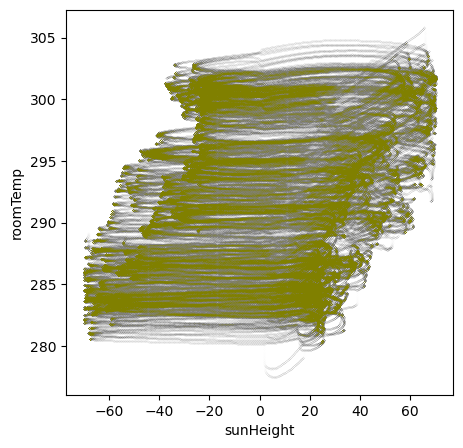

In [32]:
df.plot(kind='scatter', x='sunHeight', y='roomTemp', color='olive', s=0.00001, lw=1, figsize=(5,5))

In [33]:
df['sunHeight'].corr(df['roomTemp'])

0.33612094938294806

<Axes: xlabel='weatherTemp', ylabel='roomTemp'>

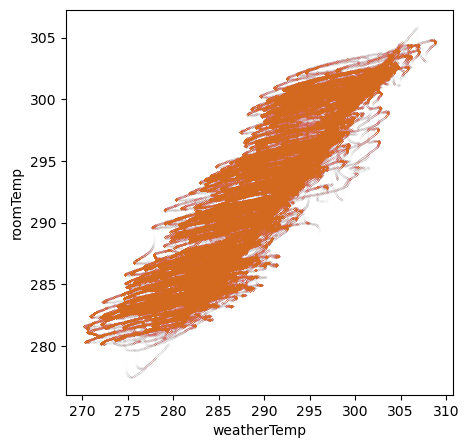

In [34]:
df.plot(kind='scatter', x='weatherTemp', y='roomTemp', c='chocolate', s=0.00001, lw=1, figsize=(5,5))

In [35]:
df['weatherTemp'].corr(df['roomTemp'])

0.9013315458539782

Among all the features available, "weatherTemp" has the strongest correlation with "roomTemperature", followed by the "sunHeight" and "windowStatus".

### Pivoting

Pivoting to reshape the data from a long list to a wide format. 

We wanted to examine how temperatures are varied based on the window status for each month. 

In [36]:
df_pivoted = df.pivot_table(index='month', columns='windowStatus', values=['weatherTemp','roomTemp'], aggfunc='mean')
df_pivoted

roomTemp                         weatherTemp              \
windowStatus           1           2           3           1           2   
month                                                                      
Apr           291.540090  291.096905  291.289726  286.291135  289.313764   
Aug           300.289017  301.326570  298.810753  295.292907  301.619754   
Dec           284.490842  284.227204         NaN  280.584190  283.081335   
Feb           284.456330  284.144113         NaN  280.593075  283.150436   
Jan           283.738860  283.468586         NaN  279.502204  282.330824   
Jul           300.766080  301.624453  299.277468  295.375773  301.485046   
Jun           297.860883  298.951845  296.644705  293.191187  299.316619   
Mar           288.204583  287.879339  288.664718  283.248812  286.550504   
May           295.432726  295.301103  295.731520  290.779726  294.336486   
Nov           287.330352  287.742673  284.221789  283.297847  287.735907   
Oct           292.245918  292.812179  289.559927  288.359481  293.125349   
Sep           295.358376  296.214705  293.202294  291.574823  297.111629   

                          
windowStatus           3  
month                     
Apr           291.054333  
Aug           298.485254  
Dec                  NaN  
Feb                  NaN  
Jan                  NaN  
Jul           298.924431  
Jun           296.379952  
Mar           288.597446  
May           295.632070  
Nov           283.410930  
Oct           288.891418  
Sep           292.708389

### Grouping

Grouping is used to analyse the features collecively based on a specific group.  

In [37]:
dfMonth = df.groupby('month').max()
dfMonth

,windspeed,sunHeight,weatherTemp,roomTemp,windowStatus,season
month,,,,,,
Apr,16.1,61.3,297.05,296.578758,3,Spring
Aug,15.0,64.9,307.15,304.708619,3,Summer
Dec,15.0,25.0,290.75,289.150000,2,Winter
Feb,15.5,38.5,291.65,287.810169,2,Winter
Jan,14.6,29.1,290.15,289.150000,2,Winter
Jul,16.1,69.9,308.85,305.849419,3,Summer
Jun,14.8,70.2,305.75,303.233224,3,Summer
Mar,14.4,50.6,295.35,294.388530,3,Spring
May,14.3,68.5,300.05,299.853838,3,Spring


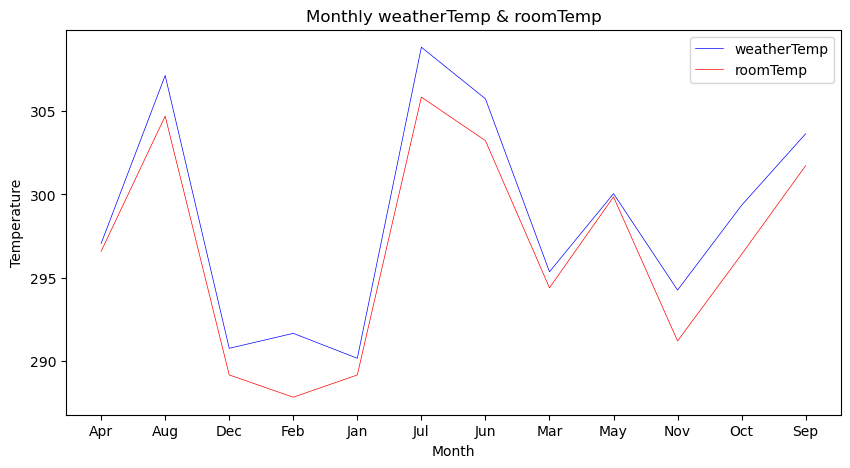

In [38]:
# Plot 'weatherTemp' and 'roomTemp' in the same subplot
plt.figure(figsize=(10, 5))
plt.plot(dfMonth.index, dfMonth['weatherTemp'], label='weatherTemp', color='blue', lw=0.5)
plt.plot(dfMonth.index, dfMonth['roomTemp'], label='roomTemp', color='red', lw=0.5)

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Monthly weatherTemp & roomTemp')
plt.legend()

# Show the plot
plt.show()

In [39]:
df.groupby('season')

In [40]:
df.groupby('season').size()

season
Autumn    917466
Spring    927548
Summer    927546
Winter    907392
dtype: int64

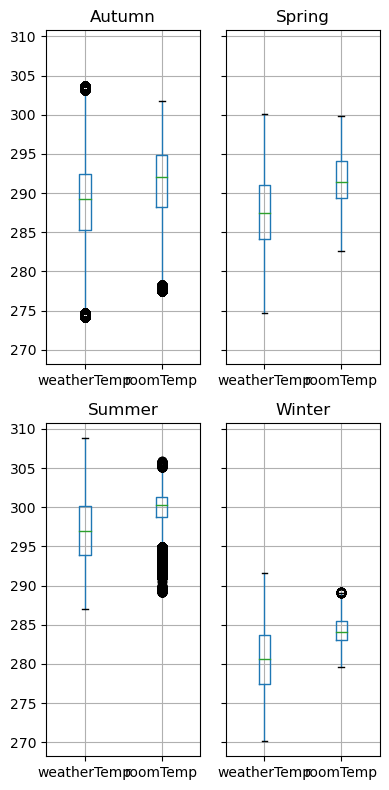

In [41]:
df[['weatherTemp', 'roomTemp', 'season']].groupby('season').boxplot(figsize=(4,8), subplots=True);

plt.tight_layout()
plt.show()

## 3. Training & Testing

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3679952 entries, 0.0 to 31536000.0
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   windspeed     float64
 1   sunHeight     float64
 2   weatherTemp   float64
 3   roomTemp      float64
 4   windowStatus  int64  
 5   month         object 
 6   season        object 
dtypes: float64(4), int64(1), object(2)
memory usage: 224.6+ MB


### Creating Train and Test Datasets for Supervised Learning

In [43]:
# Select the features (independent variables) and the target (dependent variable)
X = df[['windspeed', 'sunHeight', 'weatherTemp', 'windowStatus']]
y = df['roomTemp']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simple Linear Regression

In [44]:
# Initialize the model
linear_regression = LinearRegression()

In [45]:
# Train the model on the training data
linear_regression.fit(X_train, y_train)

LinearRegression()

In [46]:
# Predict using the model
y_pred_linear = linear_regression.predict(X_test)

In [47]:
result_linear = pd.concat([y_test, pd.DataFrame(y_pred_linear, index=y_test.index)], axis=1)
result_linear.columns = ['Actual', 'Predicted']
result_linear['Difference'] = result_linear['Actual'] - result_linear['Predicted']
result_linear.sample(5)

,Actual,Predicted,Difference
20275400.0,301.084407,301.028508,0.055898
263170.0,287.094987,287.407930,-0.312944
15359400.0,300.596552,299.461235,1.135317
13783800.0,295.784586,296.774272,-0.989687
25344500.0,291.151890,290.829669,0.322221


In [48]:
# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Print the evaluation metrics
print("Linear Regression - MSE:", mse_linear, "R-squared:", r2_linear)

Linear Regression - MSE: 5.639335636432472 R-squared: 0.8549402604978709


### K Neighbors Regressor

In [49]:
# Initialize the model
knn_regressor = KNeighborsRegressor()

In [50]:
# Train the model on the training data
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [51]:
# Predict using the model
y_pred_knn = knn_regressor.predict(X_test)

In [52]:
result_knn = pd.concat([y_test, pd.DataFrame(y_pred_knn, index=y_test.index)], axis=1)
result_knn.columns = ['Actual', 'Predicted']
result_knn['Difference'] = result_knn['Actual'] - result_knn['Predicted']
result_knn.sample(5)

,Actual,Predicted,Difference
25799800.0,291.404589,291.405719,-0.001130
24116200.0,292.124543,292.123532,0.001011
25623800.0,292.540909,292.540968,-0.000059
30925300.0,283.271309,283.270634,0.000675
19766800.0,301.801747,301.798231,0.003516


In [53]:
# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Print the evaluation metrics
print("K-Neighbors Regressor - MSE:", mse_knn, "R-squared:", r2_knn)

K-Neighbors Regressor - MSE: 0.10003681932616922 R-squared: 0.9974267687033334


### Random Forest Regressor

In [54]:
# Initialize the model
random_forest_regressor = RandomForestRegressor()

In [ ]:
# Train the model on the training data
random_forest_regressor.fit(X_train, y_train)

In [ ]:
# Predict using the model
y_pred_rf = random_forest_regressor.predict(X_test)

In [ ]:
result_rf = pd.concat([y_test, pd.DataFrame(y_pred_rf, index=y_test.index)], axis=1)
result_rf.columns = ['Actual', 'Predicted']
result_rf['Difference'] = result_rf['Actual'] - result_rf['Predicted']
result_rf.sample(5)

In [ ]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Regressor - MSE:", mse_rf, "R-squared:", r2_rf)

### Decision Tree Regressor

In [ ]:
# Initialize the model
decision_tree_regressor = DecisionTreeRegressor()

In [ ]:
# Train the model on the training data
decision_tree_regressor.fit(X_train, y_train)

In [ ]:
# Predict using the model
y_pred_dt = decision_tree_regressor.predict(X_test)

In [ ]:
result_dt = pd.concat([y_test, pd.DataFrame(y_pred_dt, index=y_test.index)], axis=1)
result_dt.columns = ['Actual', 'Predicted']
result_dt['Difference'] = result_dt['Actual'] - result_dt['Predicted']
result_dt.sample(5)

In [ ]:
# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Print the evaluation metrics
print("Decision Tree Regressor - MSE:", mse_dt, "R-squared:", r2_dt)

### Ridge Regressor

In [ ]:
# Initialize the model
ridge_regression = Ridge()

In [ ]:
# Train the model on the training data
ridge_regression.fit(X_train, y_train)

In [ ]:
# Predict using the model
y_pred_ridge = ridge_regression.predict(X_test)

In [ ]:
result_ridge = pd.concat([y_test, pd.DataFrame(y_pred_ridge, index=y_test.index)], axis=1)
result_ridge.columns = ['Actual', 'Predicted']
result_ridge['Difference'] = result_ridge['Actual'] - result_ridge['Predicted']
result_ridge.sample(5)

In [ ]:
# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print the evaluation metrics
print("Ridge Regression - MSE:", mse_ridge, "R-squared:", r2_ridge)

### Comparing Prediction Models

In [ ]:
# Create a DataFrame to store the actual and predicted values for each model
results_df = pd.DataFrame({'Actual': y_test,
                           'Linear Regression': y_pred_linear,
                           'K-Neighbors': y_pred_knn,
                           'Random Forest': y_pred_rf,
                           'Decision Tree': y_pred_dt,
                           'Ridge': y_pred_ridge})

# Drop the current index column and use 'Actual' as the new index
results_df.set_index('Actual', inplace=True)

# Display the DataFrame
results_df.sample(10)

In [ ]:
models = ['Linear','K-Neighbors', 'Random Forest', 'Decision Tree', 'Ridge']
mse_values =[mse_linear, mse_knn, mse_rf, mse_dt, mse_ridge  ]
r2_values = [r2_linear, r2_knn, r2_rf, r2_dt, r2_ridge]

# Create a DataFrame to store the evaluation metrics for each model
metrics_df = pd.DataFrame({'Model': models, 'MSE': mse_values, 'R-squared': r2_values})

metrics_df

In summary, it is found that the Random Forest and Decision Tree are the two best ML model for the given datasset. Therefore, the Random Forest model will be used for the next step which is model deployment. 

## 4. Model Deployment

The model will be used to predict the roomTemp from the user inputs received from MQTT and then the predicted roomTemp will be sent back via MQTT to the user. 

In [ ]:
import joblib

In [ ]:
# Save the model using joblib.dump()
filename = "/Users/hiz/Desktop/RWTH_3rdSem/CR_Protyping Project DSS - BIM/Project/Inzali_Berweiler_IndoorTemperaturePrediction_ss23_prototype/3_modelTrainingModule/rf_model.joblib"
joblib.dump(random_forest_regressor, filename)

print(f"Model saved as {filename}")